# Dehazing using Bilateral Filtering

In [43]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize']=[10,16]

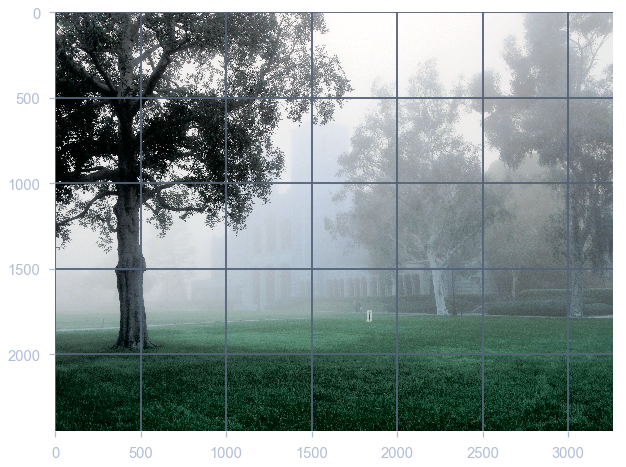

In [44]:
i_inf = 1
img = cv2.imread("fog2.jpg")

def equalise_hist_color(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_output

img = equalise_hist_color(img)
plt.imshow(img)
plt.show()

In [4]:
def initialize_airmap(img, beta= 0.9):
    img_c = img/255
    if img.shape[-1] >1:
        min_img = beta*(np.amin(img_c, axis = 2))
    else:
        min_img = beta*(img_c)
#     print (min_img.shape)
    return (min_img)

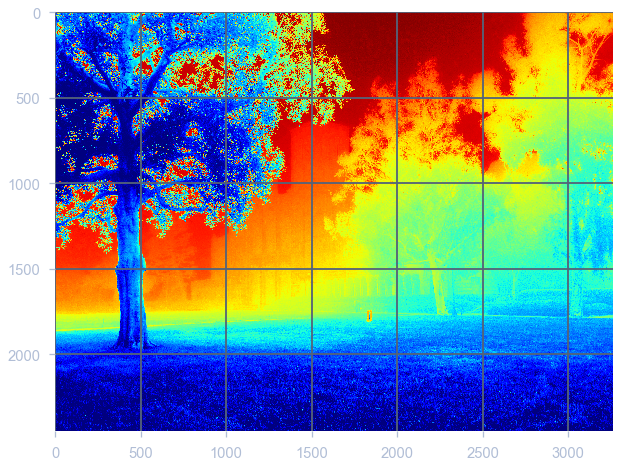

In [6]:
airmap = initialize_airmap(img)
plt.figure(figsize = (10,16))
plt.imshow(airmap, cmap = 'jet')
plt.show()

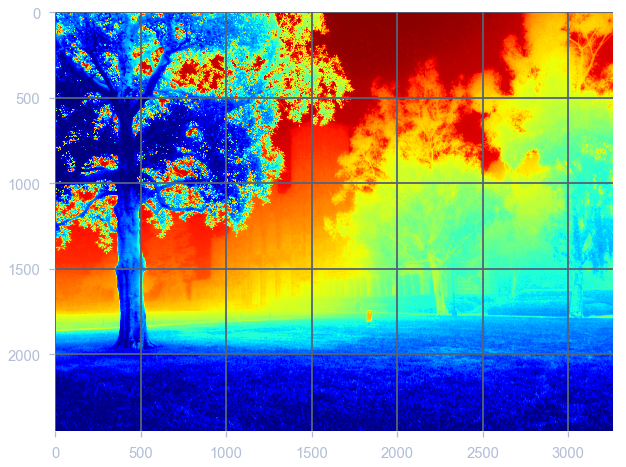

In [36]:
def refine_airmap(img):
    blur = cv2.bilateralFilter(((img)*255).astype('uint8'), 9, 75, 75)
    return blur
refine_airmap = refine_airmap(airmap)/255
plt.figure(figsize = (10,16))
plt.imshow(refine_airmap, cmap = 'jet')
plt.show()

In [13]:
def restoration(img, airmap, i_inf = [1]):
    return(((img - airmap)/(1.0 - airmap/i_inf)))

In [14]:
# This can be done with numpy array slicing (more efficient), but used this :p
b, g, r  = cv2.split(img)
b_c = restoration(b/255, refine_airmap)
g_c = restoration(g/255, refine_airmap)
r_c = restoration(r/255, refine_airmap)
img_c = cv2.merge((b_c, g_c, r_c))
img_c = (np.clip(img_c, 0, 1)*255).astype('uint8')

Text(0.5,1,'Haze Removed Process')

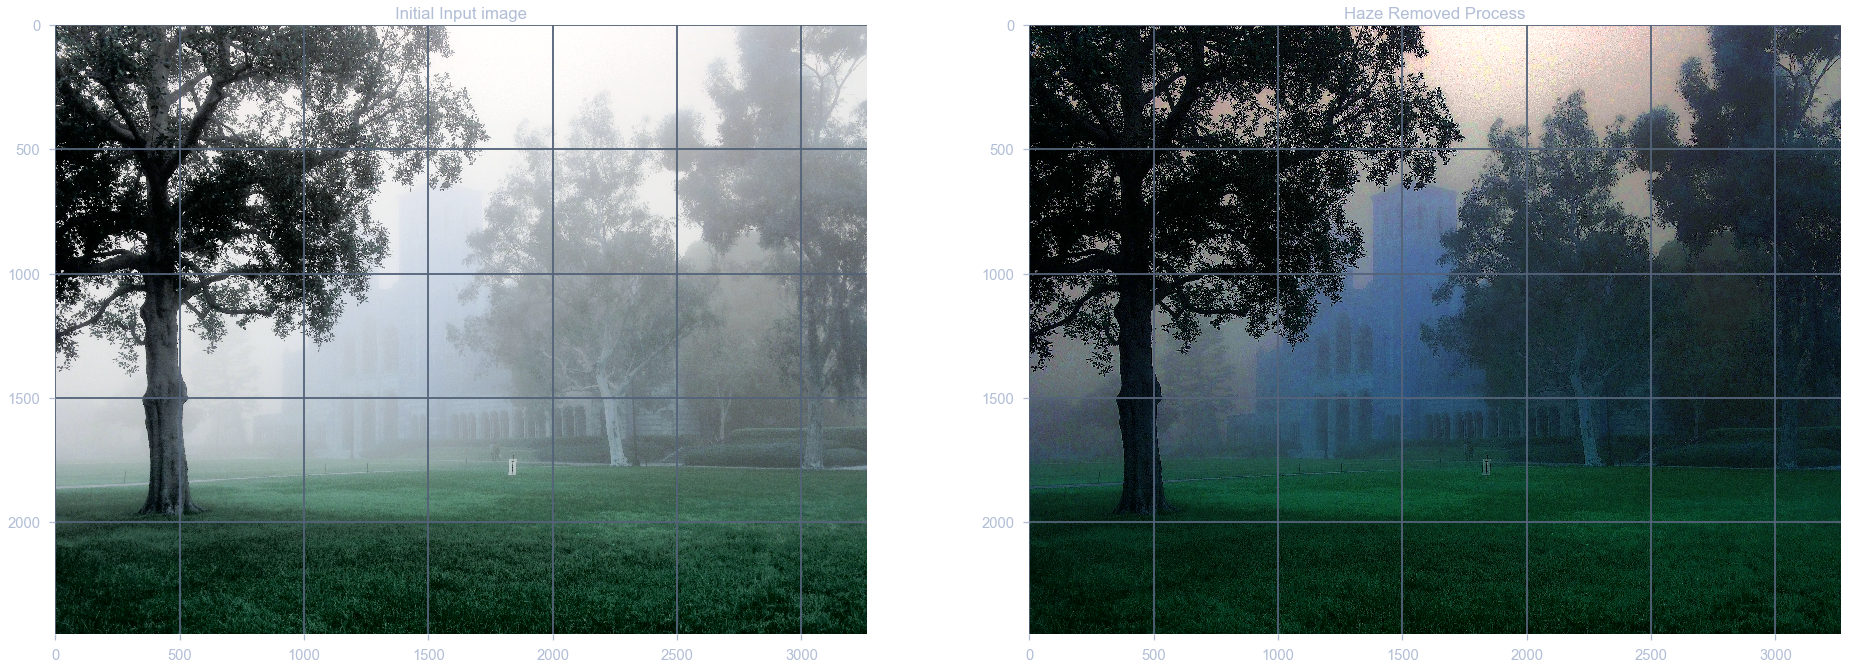

In [48]:
disp = np.hstack((img, img_c))
plt.figure(figsize = (32,16))
plt.subplot(121)
plt.imshow(img)
plt.title("Initial Input image")
plt.subplot(122)
plt.imshow(img_c)
plt.title("Haze Removed Process")
plt.show()

In [31]:
def transfer_function(img, r1, r2, s1, s2):
    ones_img = np.ones_like(img)
    m1 = (ones_img*r1 > img)
    m2 = ((img >= ones_img*r1)*(ones_img*r2 >= img))
    m3 = (img > ones_img*r2)
    img_r1 = img*(m1 .astype('uint8'))
    img_r2 = img*(m3.astype('uint8'))
    img_r1r2= img*(m2.astype('uint8'))
    img_s1 = ((s1/r1)*img_r1)*m1.astype('int')
    img_s2 = (((255.0-s2)/(255.0-r2) * (img_r2 - r2) + s2)*m3.astype('uint8'))    
    img_s1s2 = ((((s2-s1)/(r2-r1))*(img_r1r2 - r1) + s1)*m2).astype('uint8')
    img_total = img_s1 + img_s2 + img_s1s2
    return img_total
def hist_stretch(img, r_min_per = 0.1, r_max_per = 0.9, s_min_per = 0.05, s_max_per = 0.95):
    hist, bin_edges = np.histogram(img,bins = 256 ,normed = True)
    cumulative = np.cumsum(hist)
    r1 = (np.where(cumulative > r_min_per))[0][0]
    r2 = (np.where(cumulative > r_max_per))[0][0]
    s1 = int(255*s_min_per)
    s2 = int(225*s_max_per)
#     print (r1, r2, s1, s2)
    custom_stretch = transfer_function(img, r1, r2, s1, s2)
    return (custom_stretch)

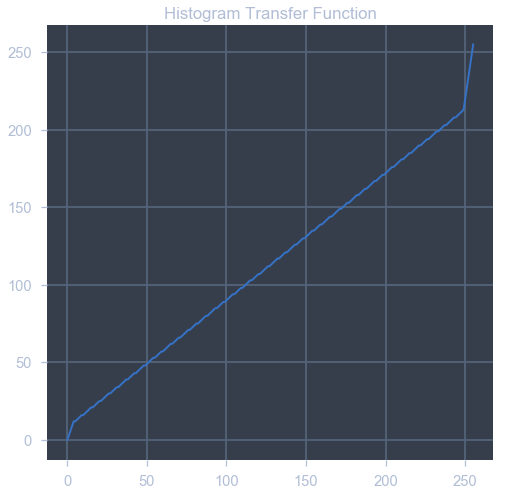

In [49]:
total = transfer_function(range(256), 4, 249, 12, 213)
plt.figure(figsize = (8,8))
plt.title("Histogram Transfer Function")
plt.plot(total)
plt.show()

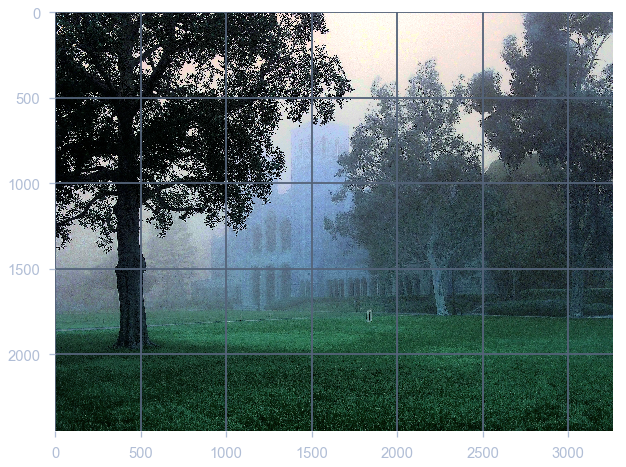

In [50]:
img_yuv = cv2.cvtColor(img_c, cv2.COLOR_BGR2YUV)
img_yuv[:,:,0] = hist_stretch(img_yuv[:,:,0])
img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
plt.imshow(img_output)
plt.show()

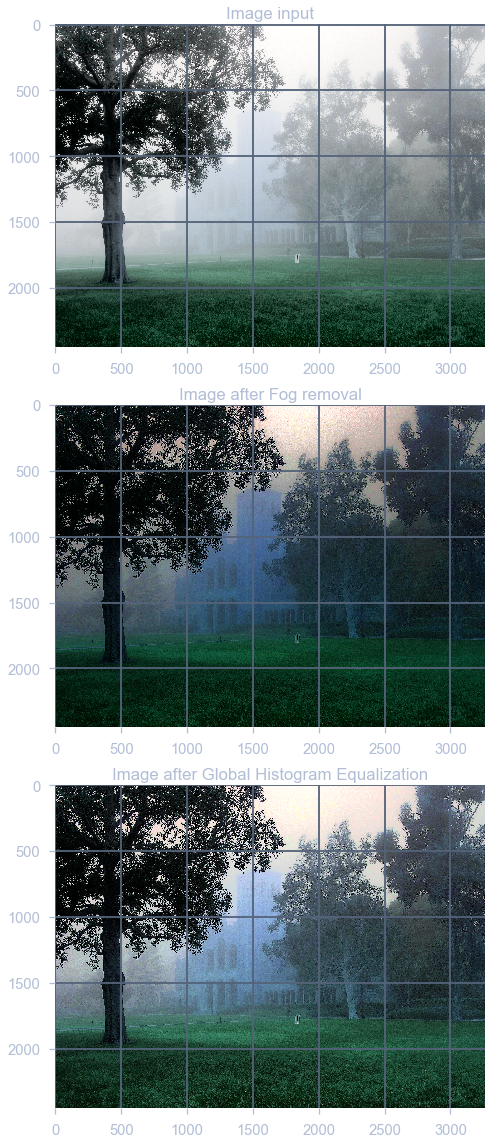

In [52]:
evolution = np.hstack((disp, img_output))
plt.figure(figsize = (32,16))
plt.subplot(311)
plt.title("Image input")
plt.imshow(img)
plt.subplot(312)
plt.title("Image after Fog removal")
plt.imshow(img_c)
plt.subplot(313)
plt.title("Image after Global Histogram Equalization")
plt.imshow(img_output)
plt.tight_layout()
plt.show()